# ML Dataset EDA - A32S Station
Exploratory Data Analysis for headway prediction dataset
- **Station:** West 4th St-Washington Square (A32S - Southbound)
- **Tracks:** A1 (local), A3 (express)
- **Date Range:** July 18, 2025 - January 19, 2026
- **Features:** headway, time_of_day, day_of_week, route_id

In [11]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery

# set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# initialize bq client
client = bigquery.Client()

In [4]:
# load data from bigquery
query = """
SELECT 
*
FROM `headway_prediction.ml`
ORDER BY  track, arrival_time
"""
df = client.query(query).to_dataframe()

# display info
print(f"Total rows {len(df):,}")
print(f"Total local track examples {len(df.loc[df['track']=='A1'])}")
print(f"Total express track examples {len(df.loc[df['track']=='A3'])}")
print(f"\nColumns: {df.columns.to_list()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nFirst few rows:")
df.head()

Total rows 75,390
Total local track examples 52085
Total express track examples 23305

Columns: ['route_id', 'direction', 'stop_id', 'track', 'stop_name', 'arrival_time', 'trip_date', 'headway', 'time_of_day_seconds', 'hour_of_day', 'day_of_week']

Data types:
route_id                            object
direction                           object
stop_id                             object
track                               object
stop_name                           object
arrival_time           datetime64[us, UTC]
trip_date              datetime64[us, UTC]
headway                            float64
time_of_day_seconds                  Int64
hour_of_day                          Int64
day_of_week                          Int64
dtype: object

First few rows:


,route_id,direction,stop_id,track,stop_name,arrival_time,trip_date,headway,time_of_day_seconds,hour_of_day,day_of_week
0,A,S,A32S,A1,W 4 St-Wash Sq,2025-07-18 08:53:57+00:00,2025-07-18 04:18:00+00:00,NaN,17637,4,6
1,A,S,A32S,A1,W 4 St-Wash Sq,2025-07-18 09:09:03+00:00,2025-07-18 04:38:00+00:00,15.100000,18543,5,6
2,E,S,A32S,A1,W 4 St-Wash Sq,2025-07-18 09:12:31+00:00,2025-07-18 04:11:30+00:00,3.466667,18751,5,6
3,E,S,A32S,A1,W 4 St-Wash Sq,2025-07-18 09:22:57+00:00,2025-07-18 04:31:30+00:00,10.433333,19377,5,6
4,A,S,A32S,A1,W 4 St-Wash Sq,2025-07-18 09:29:56+00:00,2025-07-18 04:58:00+00:00,6.983333,19796,5,6


In [5]:
# separate tracks for analysis
df_a1 = df[df.track=='A1'].copy()
df_a3 = df[df.track=='A3'].copy()

print("=" * 60)
print("Track 1 (local) - basic statistics")
print("=" * 60)
print(f"\nTotal examples: {len(df_a1):,}")
print(f"Date range {df_a1.arrival_time.min()} to {df_a1.arrival_time.max()}")
print(f"\nRoute Distribtuion")
print(df_a1.route_id.value_counts())
print(f"\nRoute percentages")
print(df_a1.route_id.value_counts(normalize=True)*100)

Track 1 (local) - basic statistics

Total examples: 52,085
Date range 2025-07-18 08:53:57+00:00 to 2026-01-19 10:43:23+00:00

Route Distribtuion
route_id
E    29170
C    17213
A     5369
F      300
M       13
B       11
D        9
Name: count, dtype: int64

Route percentages
route_id
E    56.004608
C    33.047902
A    10.308150
F     0.575982
M     0.024959
B     0.021119
D     0.017279
Name: proportion, dtype: float64


In [6]:
# Check for missing values in A1
print("Missing values in A1:")
print(df_a1.isnull().sum())
print(f"\nPercentage of rows with null headway: {(df_a1['headway'].isnull().sum() / len(df_a1)) * 100:.2f}%")

# Basic statistics for numeric features
print("\nNumeric feature statistics:")
df_a1[['headway', 'time_of_day_seconds', 'hour_of_day', 'day_of_week']].describe()


Missing values in A1:
route_id               0
direction              0
stop_id                0
track                  0
stop_name              0
arrival_time           0
trip_date              0
headway                1
time_of_day_seconds    0
hour_of_day            0
day_of_week            0
dtype: int64

Percentage of rows with null headway: 0.00%

Numeric feature statistics:


,headway,time_of_day_seconds,hour_of_day,day_of_week
count,52084.000000,52085.0,52085.0,52085.0
mean,5.116916,48305.963617,12.919017,4.031026
std,18.461235,21849.030875,6.067312,1.878039
min,0.000000,5.0,0.0,1.0
25%,2.333333,31766.0,8.0,2.0
50%,3.583333,49372.0,13.0,4.0
75%,6.166667,66492.0,18.0,6.0
max,3313.333333,86398.0,23.0,7.0


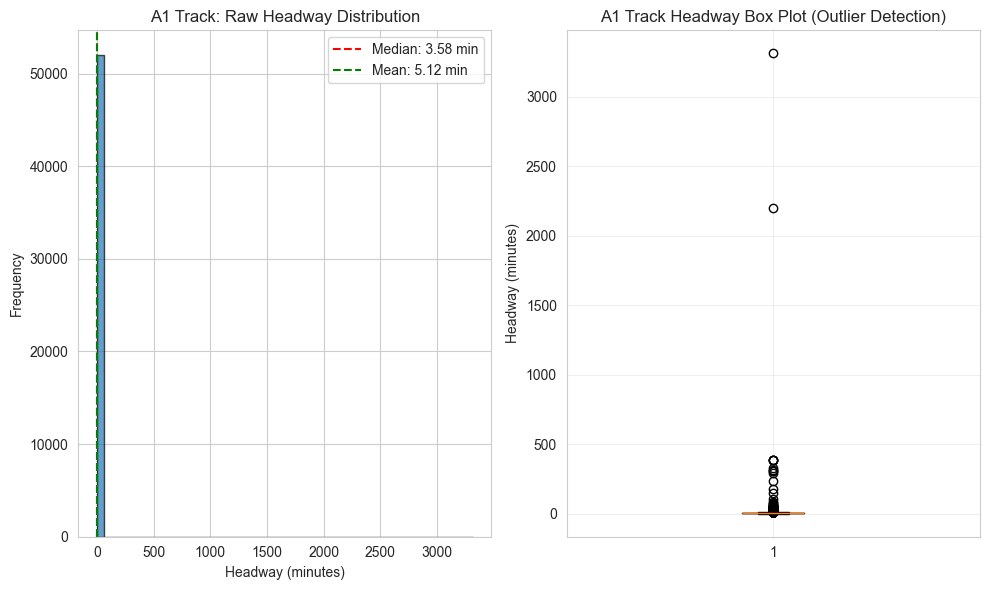


Outlier threshold (Q3 + 1.5 * IQR) 11.92 minutes
Numbe of Outliers: 3190
Percentage of outliers: 6.12%


In [13]:
# headway distribution of AW
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# histogram of raw headway
axes[0].hist(df_a1.headway.dropna(), bins=50, edgecolor="black", alpha=0.7)
axes[0].set_xlabel('Headway (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('A1 Track: Raw Headway Distribution')
axes[0].axvline(df_a1.headway.median(), color='red', linestyle='--', label=f"Median: {df_a1.headway.median():.2f} min")
axes[0].axvline(df_a1.headway.mean(), color='green', linestyle='--', label=f"Mean: {df_a1.headway.mean():.2f} min")
axes[0].legend()

# box plot to identify outliers
axes[1].boxplot(df_a1.headway.dropna(), vert=True)
axes[1].set_ylabel('Headway (minutes)')
axes[1].set_title('A1 Track Headway Box Plot (Outlier Detection)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# outlier analysis
q1 = df_a1.headway.quantile(0.25)
q3 = df_a1.headway.quantile(0.75)
iqr = q3 - q1
outlier_threshold = q3 + 1.5 * iqr
print(f"\nOutlier threshold (Q3 + 1.5 * IQR) {outlier_threshold:.2f} minutes")
print(f"Numbe of Outliers: {(df_a1.headway > outlier_threshold).sum()}")
print(f"Percentage of outliers: {((df_a1.headway > outlier_threshold).sum() / len(df_a1)) * 100:.2f}%")

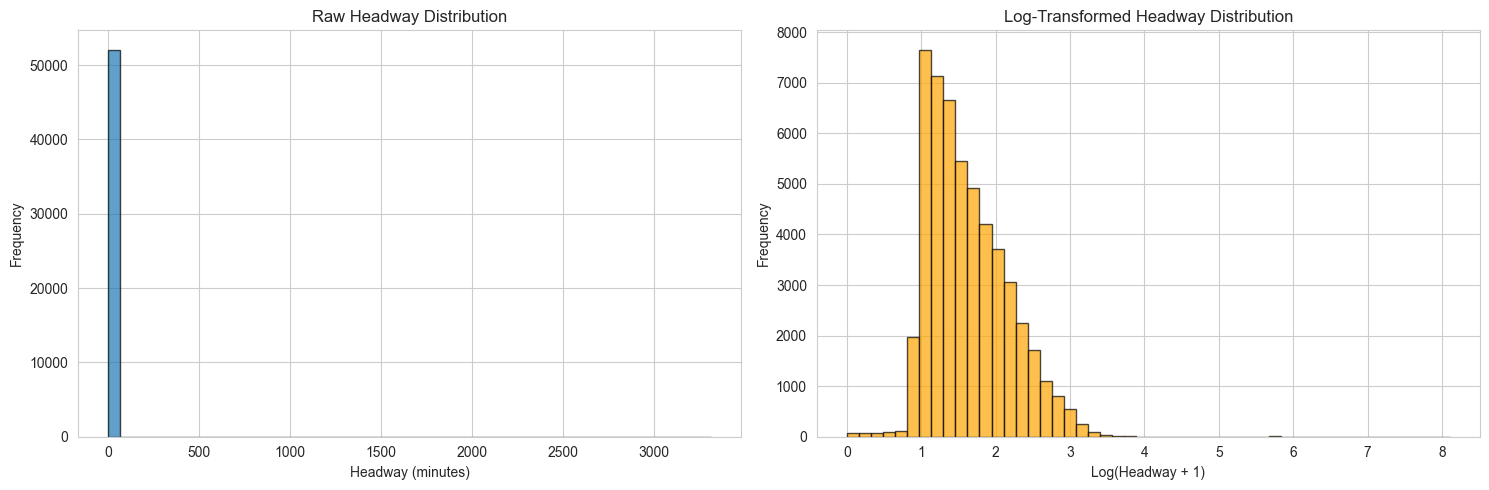

Raw headway - Skewness: 143.920
Log headway - Skewness: 0.834


In [14]:
# Check log transformation (as planned for preprocessing)
df_a1_clean = df_a1[df_a1['headway'].notna()].copy()
df_a1_clean['log_headway'] = np.log(df_a1_clean['headway'] + 1)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Raw headway
axes[0].hist(df_a1_clean['headway'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Headway (minutes)')
axes[0].set_title('Raw Headway Distribution')
axes[0].set_ylabel('Frequency')

# Log-transformed headway
axes[1].hist(df_a1_clean['log_headway'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Log(Headway + 1)')
axes[1].set_title('Log-Transformed Headway Distribution')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Raw headway - Skewness: {df_a1_clean['headway'].skew():.3f}")
print(f"Log headway - Skewness: {df_a1_clean['log_headway'].skew():.3f}")

Raw skewness: 143.920 - Extremely right-skewed<br>
Log skewness: 0.834 - Nearly normal distribution (close to 0)<br>
~170x reduction in skewness!<br>

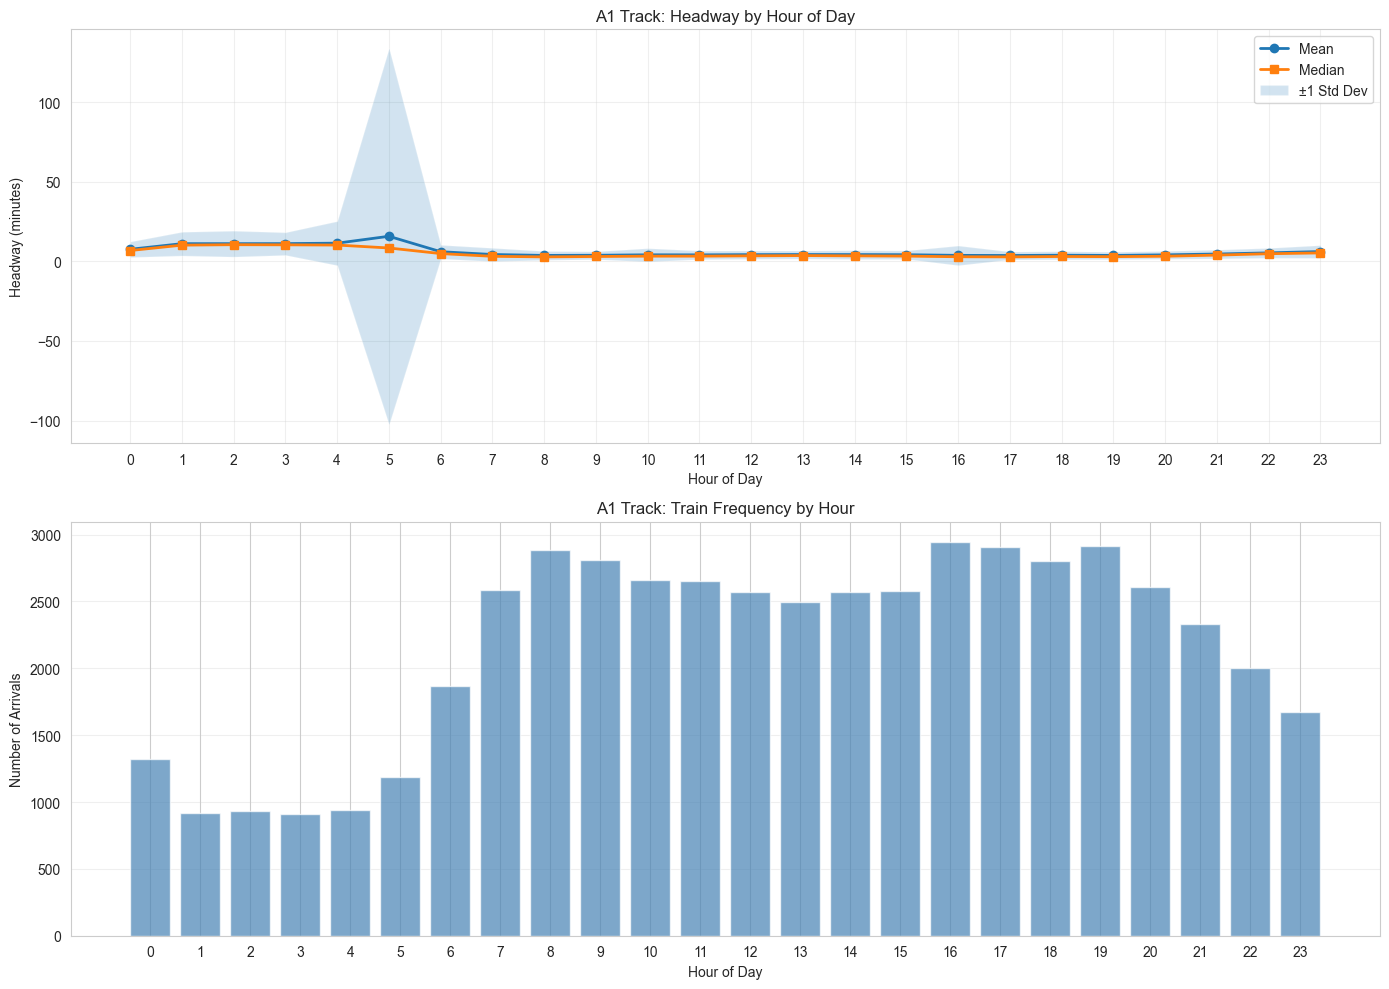


Peak hours (7-9 AM, 5-7 PM) vs Off-peak:
Peak mean headway: 3.87 min
Off-peak mean headway: 5.71 min


In [15]:
# temporal patterns
# Headway patterns by hour of day
hourly_stats = df_a1_clean.groupby('hour_of_day')['headway'].agg(['mean', 'median', 'std', 'count']).reset_index()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Mean and median headway by hour
axes[0].plot(hourly_stats['hour_of_day'], hourly_stats['mean'], marker='o', label='Mean', linewidth=2)
axes[0].plot(hourly_stats['hour_of_day'], hourly_stats['median'], marker='s', label='Median', linewidth=2)
axes[0].fill_between(hourly_stats['hour_of_day'], 
                       hourly_stats['mean'] - hourly_stats['std'], 
                       hourly_stats['mean'] + hourly_stats['std'], 
                       alpha=0.2, label='±1 Std Dev')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Headway (minutes)')
axes[0].set_title('A1 Track: Headway by Hour of Day')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24))

# Train frequency by hour
axes[1].bar(hourly_stats['hour_of_day'], hourly_stats['count'], color='steelblue', alpha=0.7)
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Number of Arrivals')
axes[1].set_title('A1 Track: Train Frequency by Hour')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xticks(range(0, 24))

plt.tight_layout()
plt.show()

# Peak vs off-peak analysis
print("\nPeak hours (7-9 AM, 5-7 PM) vs Off-peak:")
peak_hours = df_a1_clean[df_a1_clean['hour_of_day'].isin([7, 8, 9, 17, 18, 19])]
offpeak_hours = df_a1_clean[~df_a1_clean['hour_of_day'].isin([7, 8, 9, 17, 18, 19])]
print(f"Peak mean headway: {peak_hours['headway'].mean():.2f} min")
print(f"Off-peak mean headway: {offpeak_hours['headway'].mean():.2f} min")

Key Findings:<bR>
<bR>
Peak vs Off-peak: 3.87 min vs 5.71 min - ~32% shorter headway during rush hours (more frequent service)<br>
Overnight variability spike (hour 5): Huge standard deviation - those are the service gaps causing outliers<br>
Consistent daytime frequency: Hours 6-20 show steady train arrivals (~2,500-2,900 per hour)<br>
Reduced overnight service: Hours 0-5 and 22-23 show lower frequency<br>
<br>
Model Implications:
<br>
hour_of_day is a strong predictor<bR>
May need special handling for overnight periods<br>
Time-based patterns are clear and learnable<br>



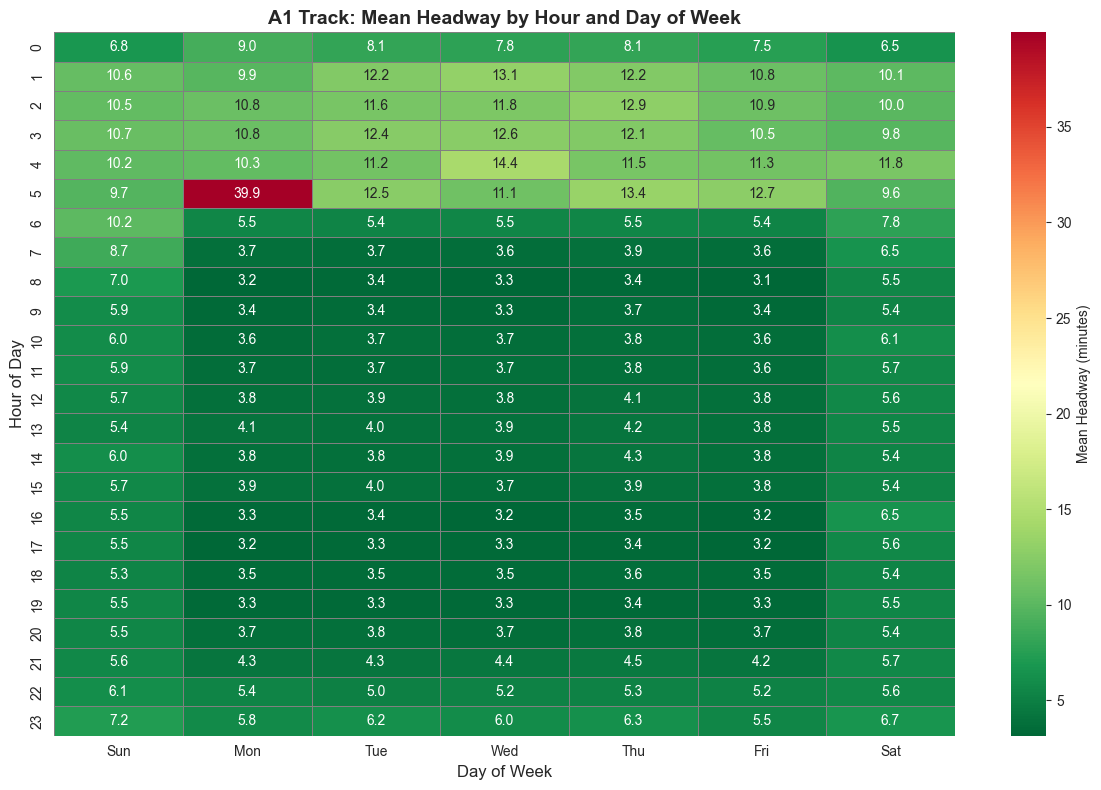

Heatmap shows:
- Red = Longer headway (less frequent service)
- Green = Shorter headway (more frequent service)
- Pattern shows clear peak/off-peak and weekday/weekend differences


In [21]:
# Heatmap: Hour of Day vs Day of Week (Mean Headway)
# Create pivot table
heatmap_data = df_a1_clean.pivot_table(
    values='headway', 
    index='hour_of_day', 
    columns='day_of_week', 
    aggfunc='mean'
)

# Map day numbers to names for better labels
day_labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
heatmap_data.columns = [day_labels[i-1] for i in heatmap_data.columns]

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Mean Headway (minutes)'},
            linewidths=0.5, linecolor='gray')
plt.title('A1 Track: Mean Headway by Hour and Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Hour of Day', fontsize=12)
plt.tight_layout()
plt.show()

print("Heatmap shows:")
print("- Red = Longer headway (less frequent service)")
print("- Green = Shorter headway (more frequent service)")
print("- Pattern shows clear peak/off-peak and weekday/weekend differences")

Key Patterns:<br>
<br>
Monday hour 5: 39.9 min - Major outlier (dark red) - likely a service transition gap<br>
Peak hours (7-9 AM, 16-19 PM): Consistently 3-4 min (dark green) across all days<br>
Overnight (0-4, 22-23): 5-12 min headways (lighter green/yellow)<br>
Weekends vs Weekdays: Subtle but visible - weekends slightly longer overall<br>
Hour 6: Clear transition from overnight to peak service (drops from ~10 min to ~5 min)<br>

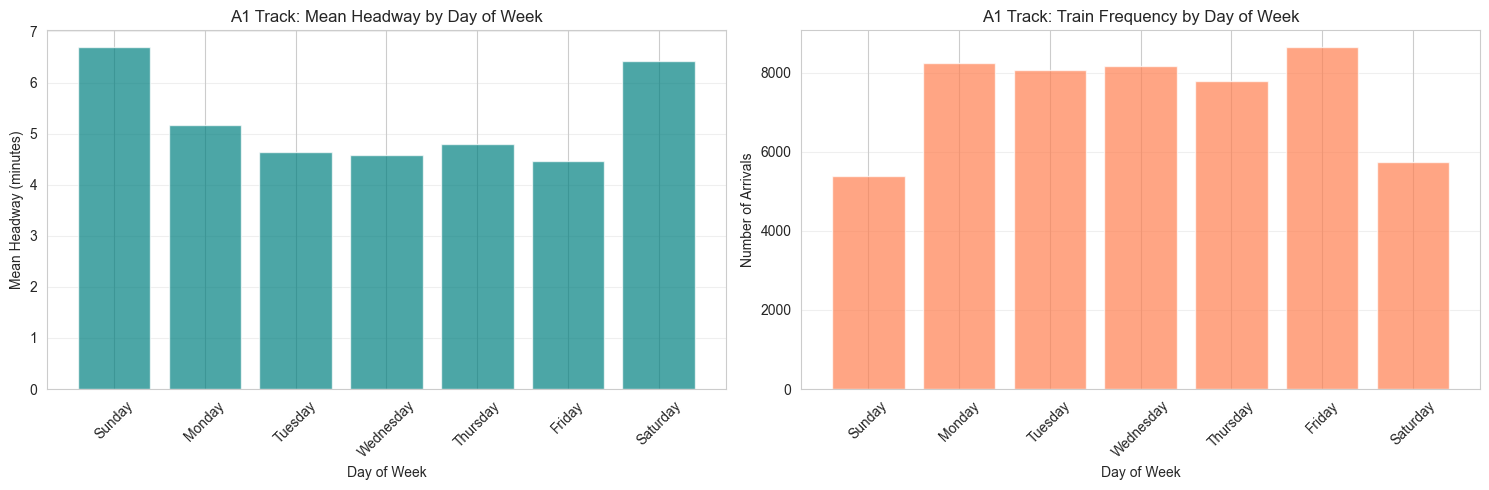


Weekday vs Weekend:
Weekday mean headway: 4.73 min
Weekend mean headway: 6.55 min
Weekday total arrivals: 40,943
Weekend total arrivals: 11,141


In [17]:
# day of week analysis
dow_stats = df_a1_clean.groupby('day_of_week')['headway'].agg(['mean', 'median', 'count']).reset_index()

# Map day numbers to names
day_names = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 
             5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
dow_stats['day_name'] = dow_stats['day_of_week'].map(day_names)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Headway by day
axes[0].bar(dow_stats['day_name'], dow_stats['mean'], color='teal', alpha=0.7)
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Mean Headway (minutes)')
axes[0].set_title('A1 Track: Mean Headway by Day of Week')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

# Frequency by day
axes[1].bar(dow_stats['day_name'], dow_stats['count'], color='coral', alpha=0.7)
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Number of Arrivals')
axes[1].set_title('A1 Track: Train Frequency by Day of Week')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Weekday vs Weekend
weekday = df_a1_clean[df_a1_clean['day_of_week'].isin([2, 3, 4, 5, 6])]  # Mon-Fri
weekend = df_a1_clean[df_a1_clean['day_of_week'].isin([1, 7])]  # Sun, Sat

print("\nWeekday vs Weekend:")
print(f"Weekday mean headway: {weekday['headway'].mean():.2f} min")
print(f"Weekend mean headway: {weekend['headway'].mean():.2f} min")
print(f"Weekday total arrivals: {len(weekday):,}")
print(f"Weekend total arrivals: {len(weekend):,}")

/var/folders/f1/dmgdbt5j5nb5ht5_vfxmr8gm0000gn/T/ipykernel_68140/1237871591.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2].boxplot([weekday['headway'].dropna(), weekend['headway'].dropna()],


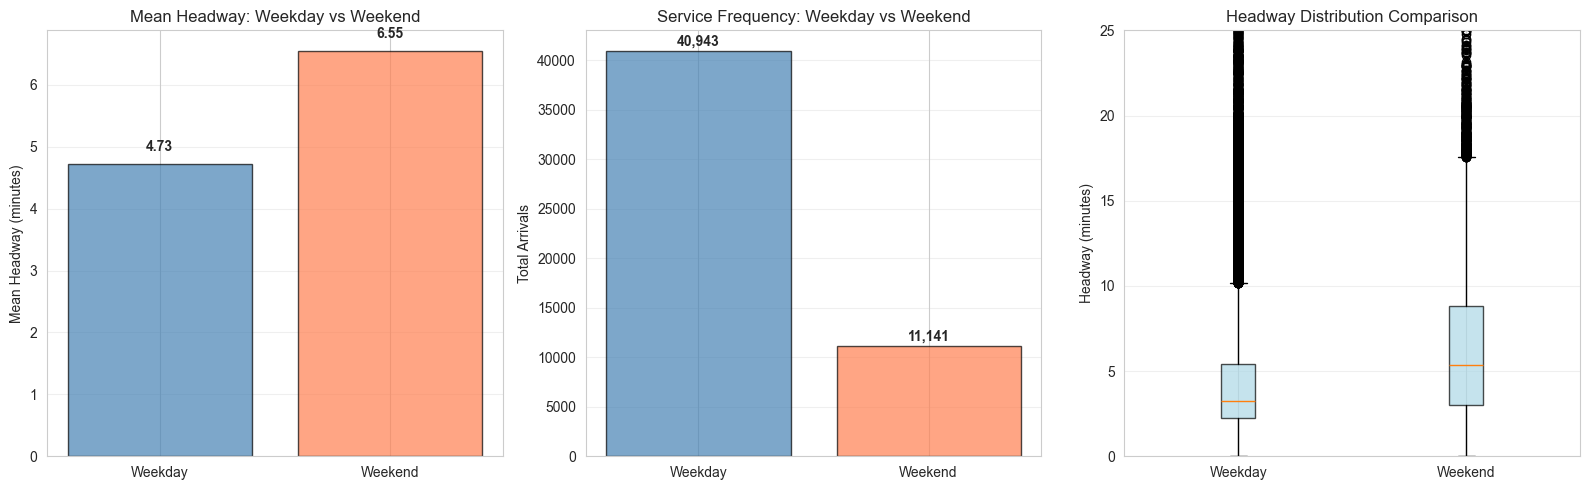


Summary Statistics:
Weekday: 40,943 arrivals, 4.73 min mean, 3.25 min median
Weekend: 11,141 arrivals, 6.55 min mean, 5.33 min median
Difference: 38.6% longer headway on weekends


In [18]:
# Summary comparison chart - Weekday vs Weekend
comparison_data = {
    'Period': ['Weekday', 'Weekend'],
    'Mean Headway (min)': [weekday['headway'].mean(), weekend['headway'].mean()],
    'Total Arrivals': [len(weekday), len(weekend)],
    'Median Headway (min)': [weekday['headway'].median(), weekend['headway'].median()]
}

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Mean headway comparison
axes[0].bar(comparison_data['Period'], comparison_data['Mean Headway (min)'], 
            color=['steelblue', 'coral'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Mean Headway (minutes)')
axes[0].set_title('Mean Headway: Weekday vs Weekend')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_data['Mean Headway (min)']):
    axes[0].text(i, v + 0.2, f'{v:.2f}', ha='center', fontweight='bold')

# Total arrivals comparison
axes[1].bar(comparison_data['Period'], comparison_data['Total Arrivals'], 
            color=['steelblue', 'coral'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Total Arrivals')
axes[1].set_title('Service Frequency: Weekday vs Weekend')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_data['Total Arrivals']):
    axes[1].text(i, v + 500, f'{v:,}', ha='center', fontweight='bold')

# Box plot comparison
axes[2].boxplot([weekday['headway'].dropna(), weekend['headway'].dropna()], 
                labels=['Weekday', 'Weekend'], patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[2].set_ylabel('Headway (minutes)')
axes[2].set_title('Headway Distribution Comparison')
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].set_ylim(0, 25)  # Zoom in to see main distribution

plt.tight_layout()
plt.show()

print("\nSummary Statistics:")
print(f"Weekday: {len(weekday):,} arrivals, {weekday['headway'].mean():.2f} min mean, {weekday['headway'].median():.2f} min median")
print(f"Weekend: {len(weekend):,} arrivals, {weekend['headway'].mean():.2f} min mean, {weekend['headway'].median():.2f} min median")
print(f"Difference: {((weekend['headway'].mean() - weekday['headway'].mean()) / weekday['headway'].mean() * 100):.1f}% longer headway on weekends")

# Express Track Dataset

In [22]:
# Track A3 (Express) - Basic Statistics
df_a3_clean = df_a3[df_a3['headway'].notna()].copy()

print("=" * 60)
print("TRACK A3 (EXPRESS) - BASIC STATISTICS")
print("=" * 60)
print(f"\nTotal examples: {len(df_a3):,}")
print(f"Clean examples (non-null headway): {len(df_a3_clean):,}")
print(f"Date range: {df_a3.arrival_time.min()} to {df_a3.arrival_time.max()}")

print(f"\nRoute Distribution:")
print(df_a3.route_id.value_counts())
print(f"\nRoute percentages:")
print(df_a3.route_id.value_counts(normalize=True) * 100)

print(f"\nMissing values:")
print(df_a3.isnull().sum())

print(f"\nNumeric feature statistics:")
print(df_a3[['headway', 'time_of_day_seconds', 'hour_of_day', 'day_of_week']].describe())

TRACK A3 (EXPRESS) - BASIC STATISTICS

Total examples: 23,305
Clean examples (non-null headway): 23,304
Date range: 2025-07-18 09:42:36+00:00 to 2026-01-19 03:39:17+00:00

Route Distribution:
route_id
A    22235
E      616
C      416
D       37
F        1
Name: count, dtype: int64

Route percentages:
route_id
A    95.408711
E     2.643210
C     1.785025
D     0.158764
F     0.004291
Name: proportion, dtype: float64

Missing values:
route_id               0
direction              0
stop_id                0
track                  0
stop_name              0
arrival_time           0
trip_date              0
headway                1
time_of_day_seconds    0
hour_of_day            0
day_of_week            0
dtype: int64

Numeric feature statistics:
            headway  time_of_day_seconds  hour_of_day  day_of_week
count  23304.000000              23305.0      23305.0      23305.0
mean      11.415924         51453.596953    13.794293      4.02935
std       43.104511         17843.804829     4

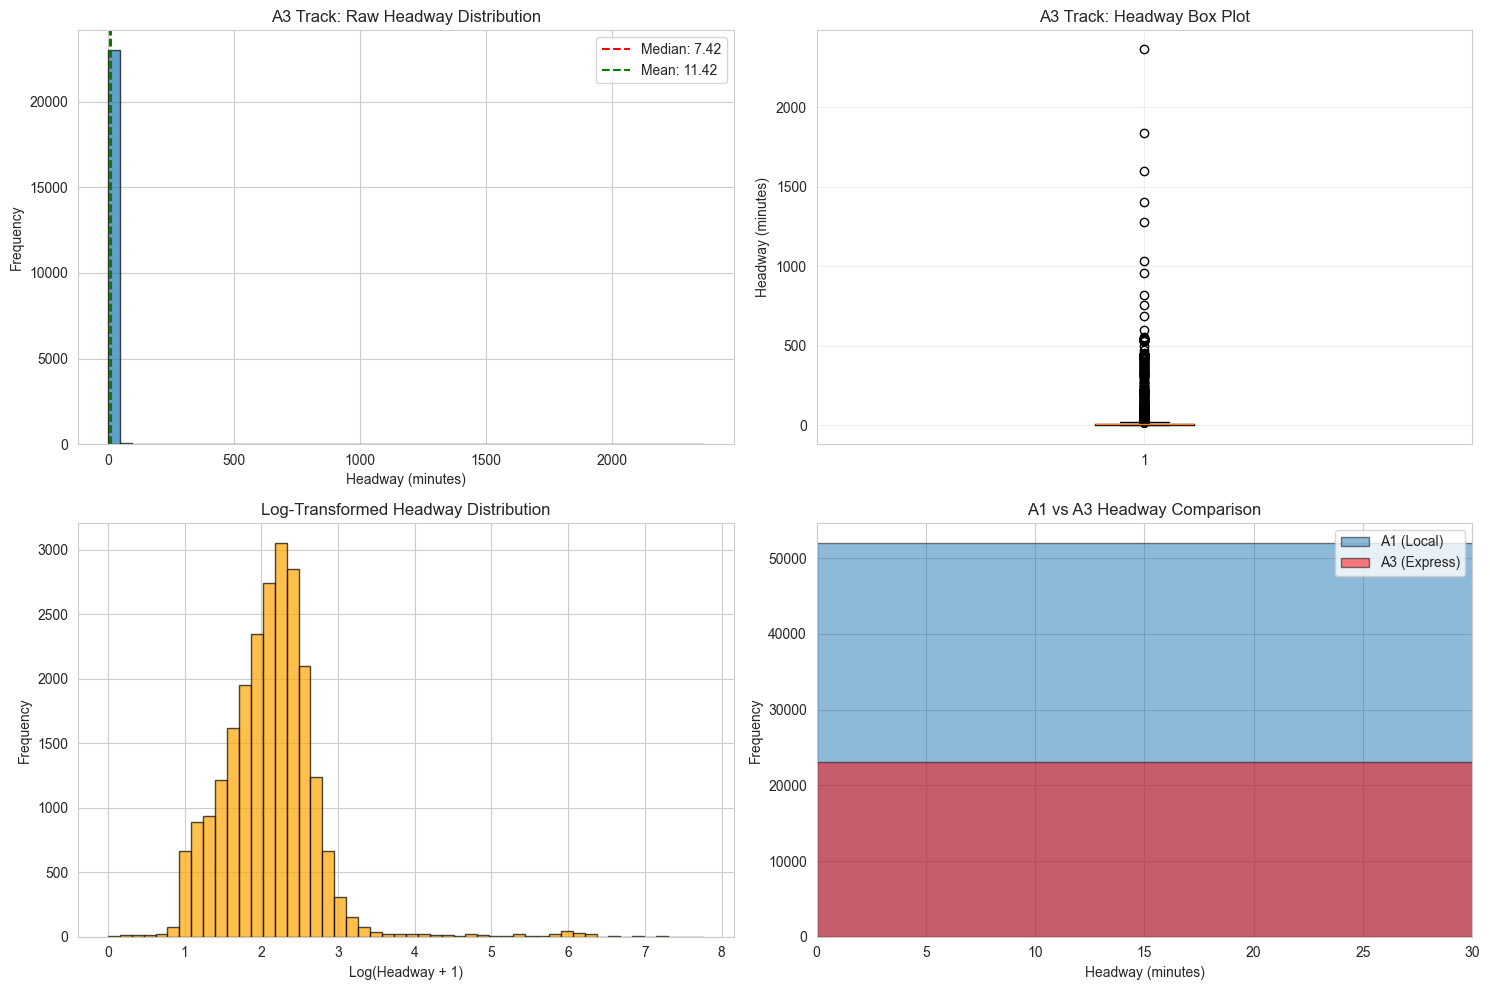


Raw headway - Skewness: 21.872
Log headway - Skewness: 1.808

Outlier threshold (Q3 + 1.5 * IQR): 18.95 minutes
Number of outliers: 781
Percentage of outliers: 3.35%


In [23]:
# A3 Headway distribution and log transformation
df_a3_clean['log_headway'] = np.log(df_a3_clean['headway'] + 1)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Raw headway histogram
axes[0, 0].hist(df_a3_clean['headway'], bins=50, edgecolor="black", alpha=0.7)
axes[0, 0].set_xlabel('Headway (minutes)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('A3 Track: Raw Headway Distribution')
axes[0, 0].axvline(df_a3_clean['headway'].median(), color='red', linestyle='--', label=f"Median: {df_a3_clean['headway'].median():.2f}")
axes[0, 0].axvline(df_a3_clean['headway'].mean(), color='green', linestyle='--', label=f"Mean: {df_a3_clean['headway'].mean():.2f}")
axes[0, 0].legend()

# Box plot
axes[0, 1].boxplot(df_a3_clean['headway'].dropna(), vert=True)
axes[0, 1].set_ylabel('Headway (minutes)')
axes[0, 1].set_title('A3 Track: Headway Box Plot')
axes[0, 1].grid(True, alpha=0.3)

# Log-transformed
axes[1, 0].hist(df_a3_clean['log_headway'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_xlabel('Log(Headway + 1)')
axes[1, 0].set_title('Log-Transformed Headway Distribution')
axes[1, 0].set_ylabel('Frequency')

# Comparison of A1 vs A3 distributions
axes[1, 1].hist(df_a1_clean['headway'], bins=50, alpha=0.5, label='A1 (Local)', edgecolor='black')
axes[1, 1].hist(df_a3_clean['headway'], bins=50, alpha=0.5, label='A3 (Express)', edgecolor='black', color='red')
axes[1, 1].set_xlabel('Headway (minutes)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('A1 vs A3 Headway Comparison')
axes[1, 1].legend()
axes[1, 1].set_xlim(0, 30)

plt.tight_layout()
plt.show()

# Outlier analysis
q1 = df_a3_clean['headway'].quantile(0.25)
q3 = df_a3_clean['headway'].quantile(0.75)
iqr = q3 - q1
outlier_threshold = q3 + 1.5 * iqr

print(f"\nRaw headway - Skewness: {df_a3_clean['headway'].skew():.3f}")
print(f"Log headway - Skewness: {df_a3_clean['log_headway'].skew():.3f}")
print(f"\nOutlier threshold (Q3 + 1.5 * IQR): {outlier_threshold:.2f} minutes")
print(f"Number of outliers: {(df_a3_clean['headway'] > outlier_threshold).sum()}")
print(f"Percentage of outliers: {((df_a3_clean['headway'] > outlier_threshold).sum() / len(df_a3_clean)) * 100:.2f}%")

Skewness:<br>
<br>
A3 Raw: 21.872 vs A1: 143.920 → A3 is ~6.5x less skewed (more regular service)<br>
A3 Log: 1.808 vs A1: 0.834 → Log transform helps A3 less (still somewhat right-skewed)<br>
Outliers:<br>
<br>
A3 threshold: 18.95 min vs A1: 11.92 min → Express has longer typical headways<br>
A3 outliers: 3.35% vs A1: 6.12% → Express has fewer extreme outliers<br>
Key Insights:<br>
<br>
Express track is more predictable - lower raw skewness suggests more consistent service intervals<br>
Longer but more regular headways - express trains run less frequently but more reliably<br>
Fewer service disruptions - lower outlier percentage<br>
From comparison plot: You can see A3 distribution (red) is shifted right - higher median/mean headway<br>
This makes sense - express trains have fewer stops, so they can maintain more consistent schedules. <br>
The log transformation may be less necessary for A3 than A1.<br>

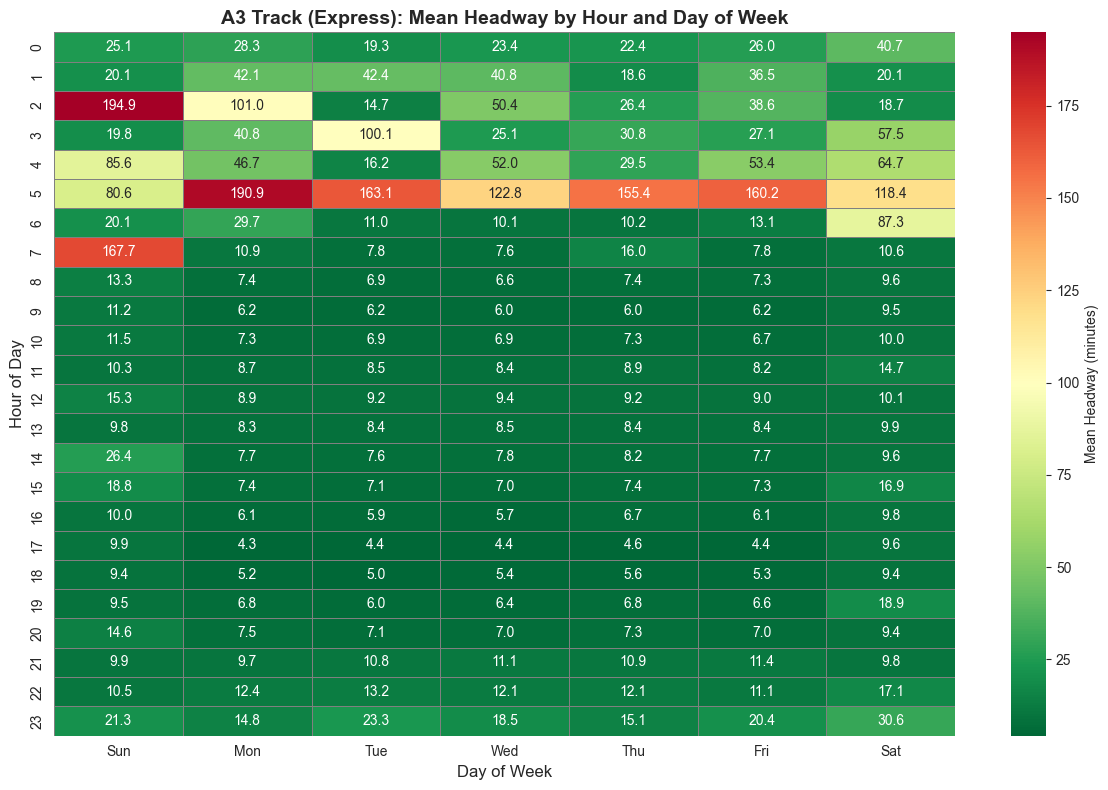


A3 Track - Weekday vs Weekend:
Weekday mean headway: 10.08 min
Weekend mean headway: 17.09 min
Difference: 69.5% longer on weekends


In [24]:
# A3 Heatmap: Hour of Day vs Day of Week
heatmap_data_a3 = df_a3_clean.pivot_table(
    values='headway', 
    index='hour_of_day', 
    columns='day_of_week', 
    aggfunc='mean'
)

day_labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
heatmap_data_a3.columns = [day_labels[i-1] for i in heatmap_data_a3.columns]

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_a3, annot=True, fmt='.1f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Mean Headway (minutes)'},
            linewidths=0.5, linecolor='gray')
plt.title('A3 Track (Express): Mean Headway by Hour and Day of Week', fontsize=14, fontweight='bold')
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Hour of Day', fontsize=12)
plt.tight_layout()
plt.show()

# Weekday vs Weekend for A3
weekday_a3 = df_a3_clean[df_a3_clean['day_of_week'].isin([2, 3, 4, 5, 6])]
weekend_a3 = df_a3_clean[df_a3_clean['day_of_week'].isin([1, 7])]

print("\nA3 Track - Weekday vs Weekend:")
print(f"Weekday mean headway: {weekday_a3['headway'].mean():.2f} min")
print(f"Weekend mean headway: {weekend_a3['headway'].mean():.2f} min")
print(f"Difference: {((weekend_a3['headway'].mean() - weekday_a3['headway'].mean()) / weekday_a3['headway'].mean() * 100):.1f}% longer on weekends")

Critical Findings:<br>

1. Extreme Overnight Outliers:<br>
Sunday hour 2: 194.9 min (over 3 hours!)<br>
Sunday hour 7: 167.7 min<br>
Hour 5 across week: 190.9, 163.1, 122.8, 155.4, 160.2 → Major service gaps<br>
<br>

2. Weekend Impact is MASSIVE:<br>
69.5% longer headways on weekends (vs A1's 28%)<br>
Weekday: 10.08 min vs Weekend: 17.09 min<br>
Express service is highly schedule-dependent<br>

3. Track Comparison (Weekday):<br>
A3 Express: 10.08 min<br>
A1 Local: 4.73 min<br>
Express runs ~2x less frequently than local<br>

4. More Variable Service:<br>
Many yellow/orange cells showing 20-60+ min gaps<br>
Less predictable than local track<br>
Overnight service especially erratic<br>
Model Implications:<br>
<br>
A3 may need separate model - very different patterns from A1<br>
day_of_week is CRITICAL predictor for A3 (weekend flag essential)<br>
Overnight hours (0-6) need special handling or filtering<br>
<br>
Consider whether to:<br>
Train separate models per track<br>
Use track as a feature in combined model<br>
Filter extreme outliers differently per track<br>
This completes the EDA! Ready to summarize findings and plan next steps?<br>



# EDA Summary & Recommendations

## Dataset Overview
- **Total Records:** 75,390 arrivals (July 18, 2025 - Jan 19, 2026)
- **Track A1 (Local):** 52,085 examples | **Track A3 (Express):** 23,305 examples
- **Station:** A32S (West 4th St - Southbound)
- **Routes:** Primarily E (56%), C (33%), A (10%) on local; A-dominant on express

---

## Key Findings

### 1. Track Characteristics - Distinct Patterns

| Metric | A1 (Local) | A3 (Express) | Insight |
|--------|-----------|--------------|---------|
| **Mean Headway** | 5.12 min | 11.42 min | Express runs 2x less frequently |
| **Median Headway** | 3.58 min | 7.42 min | Confirms frequency difference |
| **Raw Skewness** | 143.9 | 21.9 | Local has extreme outliers |
| **Outliers** | 6.12% | 3.35% | Express more predictable |
| **Weekend Impact** | +28% | +69.5% | Express weekend service drastically reduced |

**Recommendation:** Train **separate models per track** - patterns are too different to combine effectively.

---

### 2. Feature Effectiveness

#### ✅ Strong Predictors
- **`hour_of_day`:** Clear peak (7-9 AM, 5-7 PM) vs off-peak patterns
  - Peak: 3.87 min | Off-peak: 5.71 min (32% difference)
- **`day_of_week`:** Weekday vs weekend distinction critical (especially for A3)
- **`route_id`:** Composite headway captured, multiple routes per track

#### ⚠️ Temporal Features
- **`time_of_day_seconds`:** Cyclical encoding (sin/cos) will be essential
- **Overnight hours (0-6 AM):** Extreme variability - consider filtering or separate treatment

---

### 3. Data Quality

| Issue | Finding | Action |
|-------|---------|--------|
| **Missing Values** | <0.01% null headways | Negligible - drop nulls |
| **Outliers** | 6.12% (A1), 3.35% (A3) above IQR threshold | Consider capping at 120 min or use robust loss |
| **Service Gaps** | Mon hour 5: 39.9 min (A1), 194.9 min (A3 Sun) | Filter overnight hours or flag as special case |
| **Route Distribution** | ~1% "other" routes (F, M, B, D) | Acceptable - include for robustness |

---

### 4. Preprocessing Requirements

#### Log Transformation
- **A1:** Highly effective (skew: 143.9 → 0.834) ✅
- **A3:** Less effective (skew: 21.9 → 1.808) - consider MinMax scaling instead

#### Temporal Encoding
- Time of day: `sin(2π·t/86400)`, `cos(2π·t/86400)`
- Day of week: Binary weekend flag OR cyclical encoding
- Route ID: One-hot encoding (A, C, E) - 3 dimensions

#### Sequence Creation
- **Lookback window:** 10-15 previous events (based on distribution analysis)
- **Gap handling:** Break sequences at >120 min gaps (overnight service breaks)
- **Per-track processing:** Separate sequences for A1 and A3

---

### 5. Model Architecture Recommendations

#### Option A: Separate Models (RECOMMENDED)
Model A1 (Local):<br>
Input: (batch, 15, 7) - 15 events, 7 features<br>
Architecture: Stacked GRU or LSTM<br>
Loss: Huber (robust to outliers)<br>
<br>
Model A3 (Express):<br>
Input: (batch, 15, 7)<br>
Same architecture, different weights<br>
Loss: MSE (fewer outliers, more regular)<br>


**Rationale:** 
- Different service patterns (2x frequency difference)
- Weekend impact differs dramatically (28% vs 69%)
- Allows per-track optimization

#### Option B: Single Model with Track Feature
- Add `track` as binary feature (0=A1, 1=A3)
- May require more capacity to learn distinct patterns
- Risk: suboptimal performance on both tracks

---

### 6. Training Strategy

#### Data Splits (Temporal)
- **Train:** July 18 - Nov 26, 2025 (~60%)
- **Validation:** Nov 27 - Dec 27, 2025 (~20%)
- **Test:** Dec 28, 2025 - Jan 19, 2026 (~20%)

Use `timeseries_dataset_from_array()` with index ranges for clean temporal split.

#### Handling Imbalance
- A1: 52k examples | A3: 23k examples
- A3 model may need:
  - Data augmentation (jittering, sliding window overlap)
  - Transfer learning from A1 model
  - Regularization to prevent overfitting

---

## Next Steps

### Phase 1: Data Pipeline (Week 1)
1. ✅ SQL transformation complete - `ml` dataset ready
2. ⬜ Create preprocessing module (`src/data/preprocessing.py`)
   - Log transform, temporal encoding, one-hot encoding
   - Sequence generation with gap detection
   - Train/val/test split logic
3. ⬜ Build dataset loader (`src/data/dataset.py`)
   - TensorFlow `timeseries_dataset_from_array` wrapper
   - Separate loaders for A1 and A3

### Phase 2: Model Development (Week 1-2)
1. ⬜ Implement Stacked GRU architecture (`src/models/model.py`)
2. ⬜ Configure training loop (`src/training/trainer.py`)
   - Vertex AI Experiments integration
   - TensorBoard logging
   - Early stopping, checkpointing
3. ⬜ Define metrics (`src/metrics.py`)
   - MAE, RMSE for headway prediction
   - Per-hour, per-day performance breakdown

### Phase 3: Training & Evaluation (Week 2)
1. ⬜ Train A1 model (local track)
2. ⬜ Train A3 model (express track)
3. ⬜ Run evaluator on test set (`src/evaluator.py`)
4. ⬜ Generate performance report with TensorBoard visualizations

### Phase 4: Production Deployment (Week 3)
1. ⬜ Register models to Vertex AI Model Registry
2. ⬜ Deploy prediction endpoints
3. ⬜ Integration with real-time GTFS pipeline

---

## Open Questions for Next Session
1. Should we filter overnight hours (0-6 AM) or handle them separately?
2. Do we need multi-output model (headway + train type) or just headway?
3. What's the target inference latency for production?
4. Should we implement ensemble (A1 + A3 models combined)?

---

**Status:** ✅ EDA Complete | Next: Preprocessing Pipeline Development